# 1.Visual the whole network structure

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from models.graphModel import GraphModel
from configs.config import get_config
cfg = get_config()

model = GraphModel(cfg)
checkpoint = torch.load(r'experiments\checkpoints\latest.pth')
# checkpoint = torch.load(r'experiments\checkpoints\latest.pth')
model.load_state_dict(checkpoint["model"], strict=False)

d:\anaconda3\envs\2torch1.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [2]:
#---------------------------------#
# fetch data for example 
#---------------------------------#
from utils.graphDataset import GraphDataset
test_dataset = GraphDataset(cfg,'Train_split')
raw_tra_graph,raw_det_graph,gt_matrix = test_dataset.__getitem__(0)
raw_tra_graph,raw_det_graph

[Train_split] Data-preprocess: 100%|██████████| 7/7 [00:00<00:00,  7.96seq/s]
2024-12-04 15:04:57.749 | INFO     | utils.graphDataset:__init__:85 - [Train_split] Data-preprocess complete!
2024-12-04 15:04:57.749 | INFO     | utils.graphDataset:__init__:86 - [Train_split] Total frame number : 4609


(Data(x=[32, 3, 224, 224], location_info=[32, 4]),
 Data(x=[32, 3, 224, 224], location_info=[32, 4]))

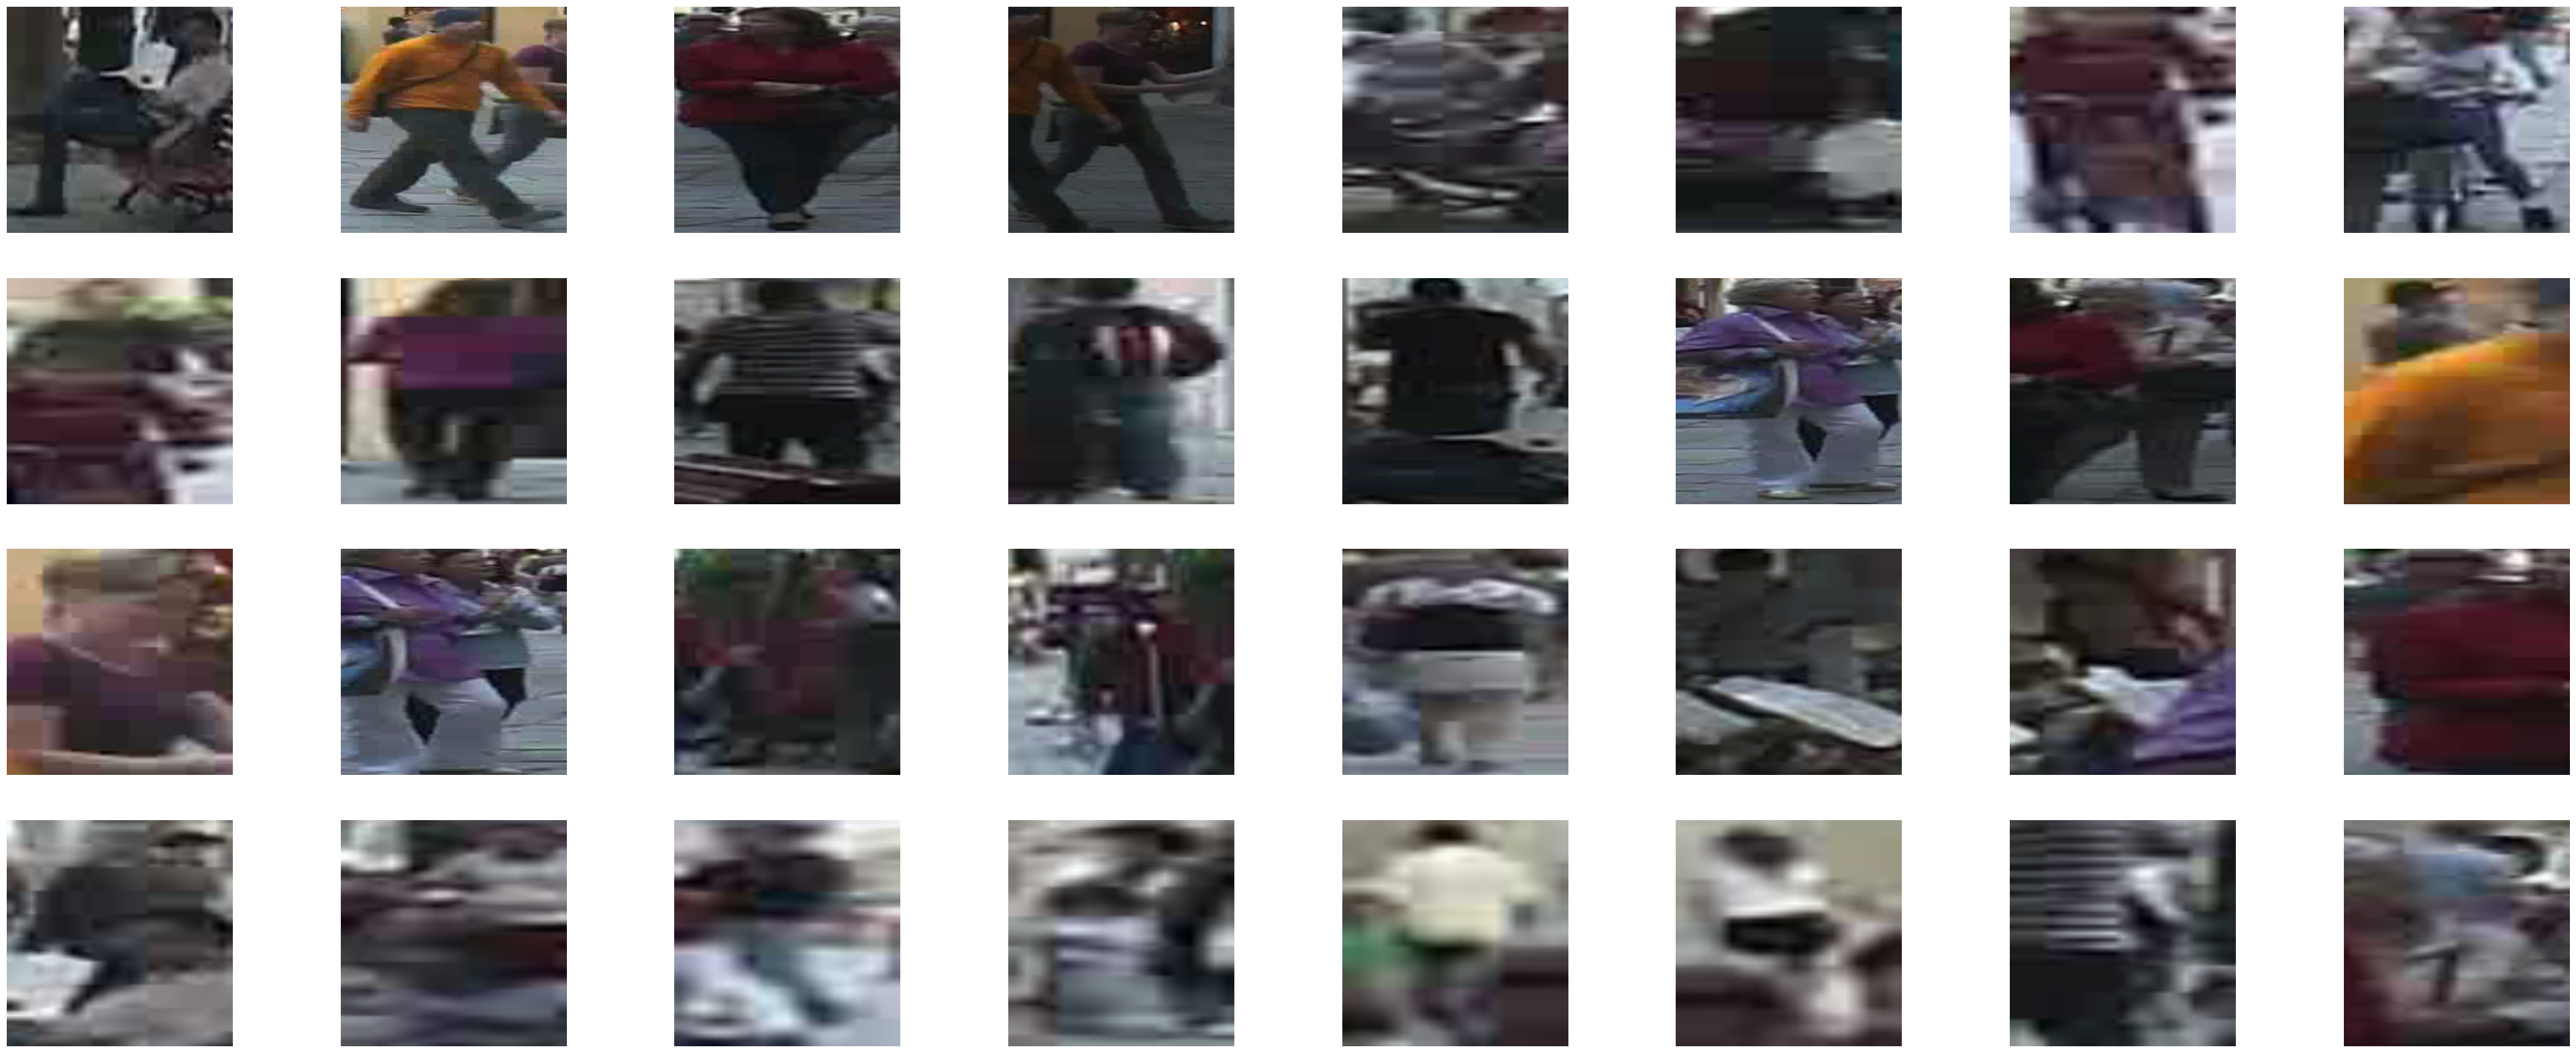

In [3]:
#---------------------------------#
#  raw graph stores resized raw images so we can visulize them 
#---------------------------------#

import math
from matplotlib import pyplot as plt
def scale_patch_to_0_1(patch):
    """将裁剪后的图像patch缩放到[0, 1]范围内"""
    patch_max = torch.max(patch)
    patch_min = torch.min(patch)
    patch = (patch - patch_min) / (patch_max - patch_min)  # 确保像素值在 [0, 1] 范围
    return patch 
# import torchvision.transforms.functional as F
tra_obj_ims = raw_tra_graph.x
num_tra    = tra_obj_ims.shape[0] 
num_rows = math.ceil(num_tra / 8)
fig, axs   = plt.subplots(num_rows, 8, figsize=(50, 20))
# # plt.imshow(tra_obj_im)

for i in range(num_tra):
    row = i //8
    col = i % 8
    patch = scale_patch_to_0_1(tra_obj_ims[i])
    axs[row,col].imshow(patch.permute(1,2,0).numpy())
    axs[row,col].axis('off')
plt.show()

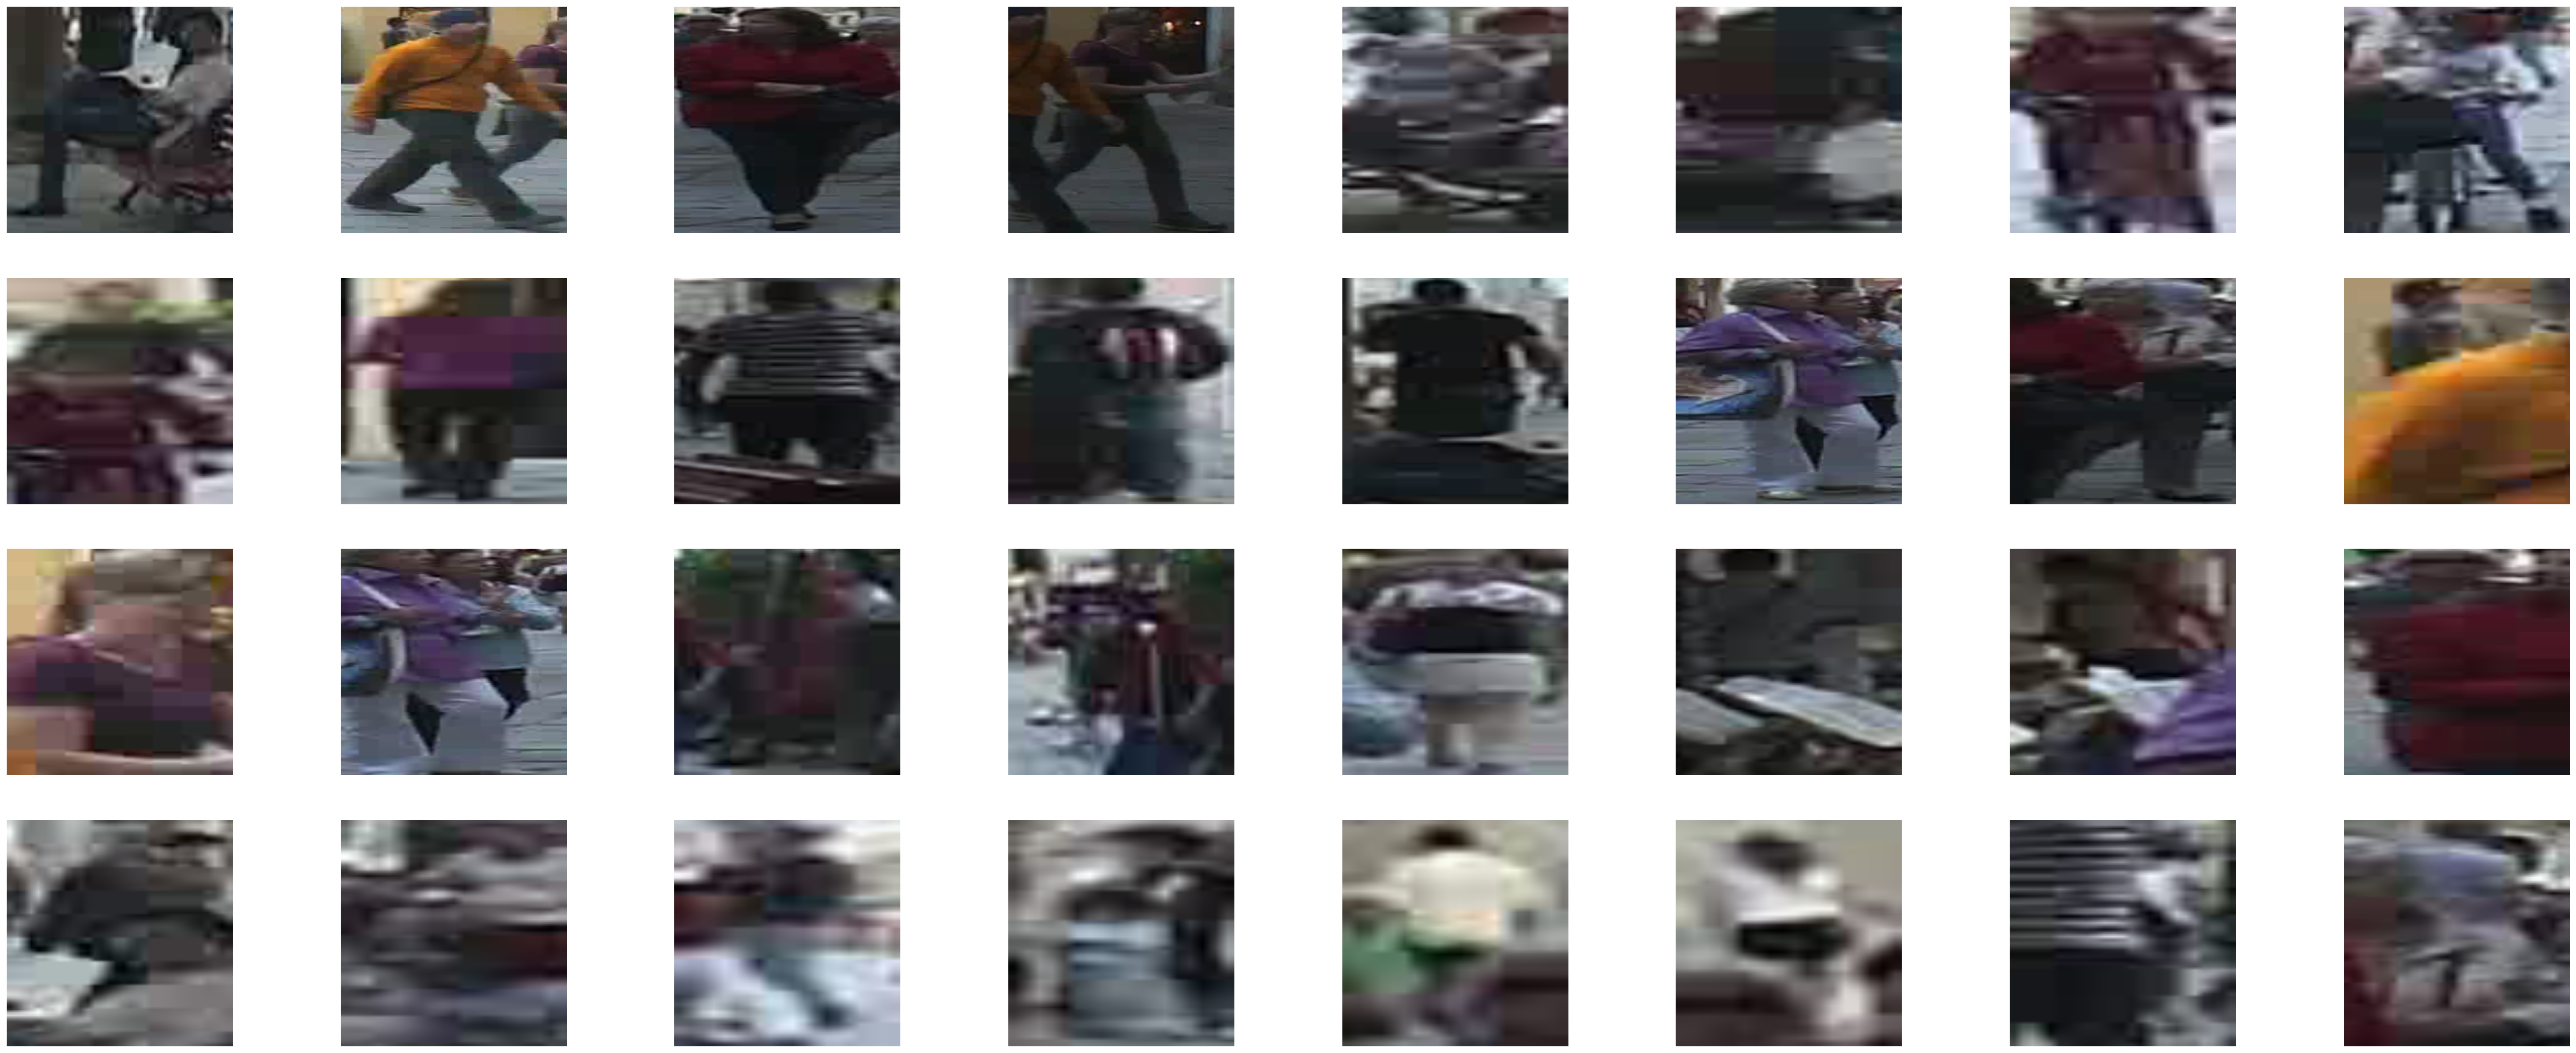

In [4]:
det_obj_ims = raw_det_graph.x
num_tra    = det_obj_ims.shape[0] 
num_rows = math.ceil(num_tra / 8)
fig, axs   = plt.subplots(num_rows, 8, figsize=(50, 20))
# # plt.imshow(tra_obj_im)

for i in range(num_tra):
    row = i //8
    col = i % 8
    patch = scale_patch_to_0_1(det_obj_ims[i])
    axs[row,col].imshow(patch.permute(1,2,0).numpy())
    axs[row,col].axis('off')
plt.show()

### ps I wanna figure out the `the point less than k`

In [3]:
from torch.utils.data import DataLoader
from utils.graphDataset import graph_collate_fn
from models.graphEncoder import NodeEncoder,EdgeEncoder
dataloader = DataLoader(test_dataset,batch_size=4,shuffle=True,
                        pin_memory=False if cfg.DEVICE.startswith('cuda') and torch.cuda.is_available() else True,
                        num_workers=cfg.NUM_WORKS,collate_fn=graph_collate_fn,drop_last=True)
nodeEncoder = NodeEncoder(32)
edgeEncoder = EdgeEncoder(18)
data_iter = iter(dataloader)
# raw_det_graph,raw_tra_graph,gt_matrix = next(data_iter)

In [128]:
#---------------------------------#
# fetch data 
#---------------------------------# 

raw_tra_graph,raw_det_graph,gt_matrix = next(data_iter)
# graph = nodeEncoder(raw_det_graph)
# graph = edgeEncoder(graph,2)
r = edgeEncoder.construct_edge_index(raw_tra_graph,2)
raw_det_graph,raw_tra_graph,r.shape

MOT17-11-FRCNN*742
MOT17-02-FRCNN*142
MOT17-13-FRCNN*498


2024-11-30 22:08:33.275 | WARNING  | models.graphToolkit:knn:38 - SPECIAL SITUATIONS: The number of points is less than k, set k to 1


MOT17-11-FRCNN*264


(Batch(x=[64, 3, 224, 224], location_info=[64, 4], batch=[64], ptr=[5]),
 Batch(x=[62, 3, 224, 224], location_info=[62, 4], batch=[62], ptr=[5]),
 torch.Size([2, 184]))

In [133]:
# analyze
raw_tra_graph,raw_tra_graph.batch

(Batch(x=[62, 32], location_info=[62, 4], batch=[62], ptr=[5]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

In [141]:
from models.graphToolkit import knn
for i in range(2,raw_tra_graph.num_graphs):
    part_location_info = raw_tra_graph.location_info[raw_tra_graph.batch == i]
    print('Here is location info')
    print(part_location_info)
    edge_index = knn(part_location_info,2,bt_edge_index=True)
    print('Here is edge index')
    print(edge_index)
    break

2024-11-30 22:19:17.057 | WARNING  | models.graphToolkit:knn:38 - SPECIAL SITUATIONS: The number of points is less than k, set k to 1


Here is location info
tensor([[  81.0000,  263.0000, 1112.5000,  812.5000],
        [  78.0000,  253.0000, 1188.0000,  821.5000]])
Here is edge index
tensor([[1, 0],
        [0, 1]])


In [146]:
# focus data MOT17-13-FRCNN*498
# lets read the data 
txt_path = r'datasets\MOT17\train\MOT17-13-SDP\gt\gt.txt'
import numpy as np 
gt = np.loadtxt(txt_path,delimiter=',')
# 获取第一个数字列
first_column = gt[:, 0]

# 创建布尔索引，筛选出第一个数字在488到498范围内的行
mask = (first_column >= 488) & (first_column <= 498)
gt[mask].astype(np.int32)

array([[ 488,   20,  347,  901,  173,  436,    1,    1,    0],
       [ 489,   20,  300,  915,  168,  425,    1,    1,    0],
       [ 490,   20,  250,  927,  163,  416,    1,    1,    0],
       [ 491,   20,  200,  940,  158,  407,    1,    1,    0],
       [ 492,   20,  137,  944,  161,  403,    1,    1,    0],
       [ 493,   20,   74,  949,  164,  399,    1,    1,    0],
       [ 494,   20,   11,  953,  167,  395,    1,    1,    0],
       [ 495,   20,  -52,  958,  170,  391,    1,    1,    0],
       [ 488,   21, 1496,  658,   99,  235,    1,    1,    0],
       [ 489,   21, 1442,  661,  111,  235,    1,    1,    0],
       [ 490,   21, 1397,  665,  110,  236,    1,    1,    0],
       [ 491,   21, 1352,  669,  110,  238,    1,    1,    0],
       [ 492,   21, 1307,  674,  110,  239,    1,    1,    0],
       [ 493,   21, 1275,  675,  102,  246,    1,    1,    0],
       [ 494,   21, 1243,  677,   95,  252,    1,    1,    0],
       [ 495,   21, 1211,  679,   88,  259,    1,    1,

In [147]:
test_dataset.dets_dict['MOT17-13-FRCNN'][493]

[[493, 20, 74.0, 949.0, 164.0, 399.0, 156.0, 1148.5],
 [493, 21, 1275.0, 675.0, 102.0, 246.0, 1326.0, 798.0],
 [493, 22, 1375.0, 683.0, 81.0, 241.0, 1415.5, 803.5]]

In [154]:
tracklets_dict = {}
cut_from_frame = max(1,498 - test_dataset.trackback_window)
for frame_idx in range(cut_from_frame,498):
    print(frame_idx)
    past_detections = test_dataset.dets_dict['MOT17-13-FRCNN'][frame_idx]
    for past_det in past_detections: # past_det = [frame_idx,tracklet_id,x,y,w,h,xc,yc]
        tracklet_id = past_det[1]
        if tracklet_id not in tracklets_dict:
            tracklets_dict[tracklet_id] = []
        tracklets_dict[tracklet_id].append(past_det)
tracklets_dict

488
489
490
491
492
493
494
495
496
497


{20: [[488, 20, 347.0, 901.0, 173.0, 436.0, 433.5, 1119.0],
  [489, 20, 300.0, 915.0, 168.0, 425.0, 384.0, 1127.5],
  [490, 20, 250.0, 927.0, 163.0, 416.0, 331.5, 1135.0],
  [491, 20, 200.0, 940.0, 158.0, 407.0, 279.0, 1143.5],
  [492, 20, 137.0, 944.0, 161.0, 403.0, 217.5, 1145.5],
  [493, 20, 74.0, 949.0, 164.0, 399.0, 156.0, 1148.5],
  [494, 20, 11.0, 953.0, 167.0, 395.0, 94.5, 1150.5]],
 21: [[488, 21, 1496.0, 658.0, 99.0, 235.0, 1545.5, 775.5],
  [489, 21, 1442.0, 661.0, 111.0, 235.0, 1497.5, 778.5],
  [490, 21, 1397.0, 665.0, 110.0, 236.0, 1452.0, 783.0],
  [491, 21, 1352.0, 669.0, 110.0, 238.0, 1407.0, 788.0],
  [492, 21, 1307.0, 674.0, 110.0, 239.0, 1362.0, 793.5],
  [493, 21, 1275.0, 675.0, 102.0, 246.0, 1326.0, 798.0],
  [494, 21, 1243.0, 677.0, 95.0, 252.0, 1290.5, 803.0],
  [495, 21, 1211.0, 679.0, 88.0, 259.0, 1255.0, 808.5],
  [496, 21, 1164.0, 679.0, 86.0, 261.0, 1207.0, 809.5],
  [497, 21, 1118.0, 680.0, 84.0, 262.0, 1160.0, 811.0]],
 22: [[488, 22, 1588.0, 661.0, 86.0,

In [155]:
detections = [item[-1] for item in list(tracklets_dict.values())]
detections

[[494, 20, 11.0, 953.0, 167.0, 395.0, 94.5, 1150.5],
 [497, 21, 1118.0, 680.0, 84.0, 262.0, 1160.0, 811.0],
 [497, 22, 1194.0, 695.0, 78.0, 252.0, 1233.0, 821.0]]

In [156]:
location_info = []
for det in detections:
    print(det[4:])
    location_info.append(det[4:])
location_info = torch.as_tensor(location_info,dtype=torch.float32)
location_info

[167.0, 395.0, 94.5, 1150.5]
[84.0, 262.0, 1160.0, 811.0]
[78.0, 252.0, 1233.0, 821.0]


tensor([[ 167.0000,  395.0000,   94.5000, 1150.5000],
        [  84.0000,  262.0000, 1160.0000,  811.0000],
        [  78.0000,  252.0000, 1233.0000,  821.0000]])

## 1.2 visulize the node Embedding feature map 

In [6]:
# #---------------------------------#
# #  tracklet graph first 
# #---------------------------------#
tra_graph = model.graphconvLayer.nodeEncoder(raw_tra_graph.clone())


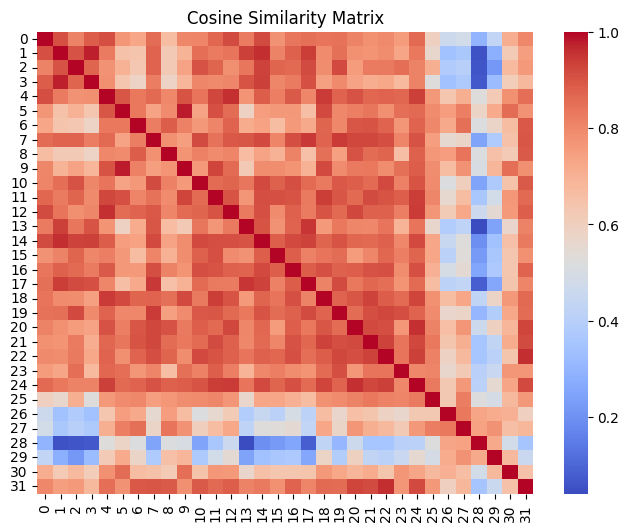

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F 

#---------------------------------#
#  轨迹图
#---------------------------------#


node_embed = tra_graph.x
cos_sim_matrix = F.cosine_similarity(node_embed.unsqueeze(0), node_embed.unsqueeze(1), dim=2)
plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(cos_sim_matrix.detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("Cosine Similarity Matrix")

# 显示图像
plt.show()

## 1.3 Affinity matrix visullization

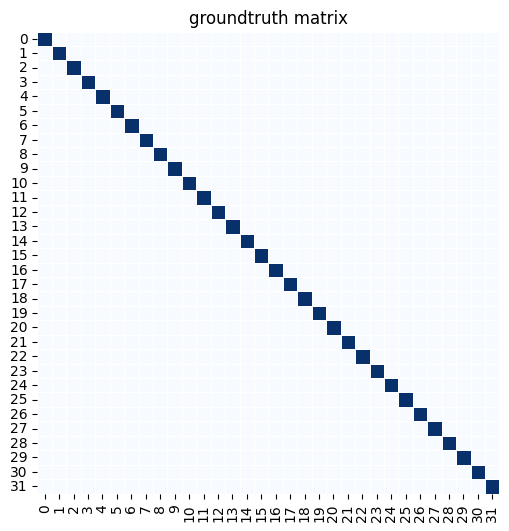

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F 

plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(gt_matrix, annot=False, cmap='Blues', cbar=False, linewidths=0.5, square=True)

# 添加标题
plt.title("groundtruth matrix")

# 显示图像
plt.show()

In [3]:
# raw_det_graph.x.to('cuda')
# # raw_det_graph.location_info.to('cuda')
# # raw_tra_graph.x.to('cuda')
# # raw_tra_graph.location_info.to('cuda')
# # model.eval()
# model.to('cuda')
match_mtx_list = model(raw_tra_graph,raw_det_graph)

Text(0.5, 1.0, 'affinity matrix')

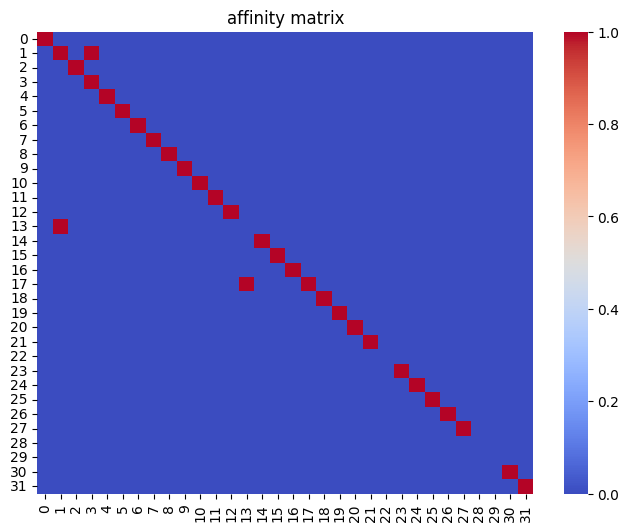

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # 设置热图大小
sns.heatmap(match_mtx_list[0][:-1,:-1].detach().numpy() > 0.1, cmap='coolwarm', cbar=True)

# 添加标题
plt.title("affinity matrix")

In [5]:
match_mtx_list[0]

tensor([[0.1549, 0.0243, 0.0183,  ..., 0.0264, 0.0167, 0.0209],
        [0.0265, 0.1247, 0.0341,  ..., 0.0215, 0.0564, 0.0201],
        [0.0159, 0.0201, 0.1107,  ..., 0.0167, 0.0240, 0.0200],
        ...,
        [0.0273, 0.0198, 0.0263,  ..., 0.1692, 0.0149, 0.0222],
        [0.0188, 0.0620, 0.0332,  ..., 0.0146, 0.1424, 0.0206],
        [0.0206, 0.0188, 0.0212,  ..., 0.0216, 0.0202, 0.3234]],
       grad_fn=<ExpBackward>)

In [6]:
torch.sum(match_mtx_list[0], dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

In [7]:
torch.sum(match_mtx_list[0], dim=0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

In [16]:
from models.lossFunc import GraphLoss
lossfunc = GraphLoss()
lossfunc(match_mtx_list,[gt_matrix])

tensor([0.0216], grad_fn=<DivBackward0>)

In [13]:
torch.all(~torch.isnan(gt_matrix) )

tensor(True)

In [17]:
from torch_geometric.data import Batch,Data
a = Batch.from_data_list([raw_det_graph])
isinstance(a,Data)

True

# 2. 测试Lapjv以及Hungarian Algorithm

In [19]:
import lap
from models.graphToolkit import hungarian
import datetime
import time

start = time.perf_counter()
b_mtx = hungarian(match_mtx_list[0][:-1,:-1])
end = time.perf_counter()
datetime.timedelta(seconds=end - start)

datetime.timedelta(microseconds=423)

In [20]:
b_mtx.shape

torch.Size([32, 32])

In [ ]:
import scipy.optimize as opt
import numpy as np
match_thresh = 0.1
affinity_mtx = match_mtx_list[0][:-1,:-1].cpu().detach().numpy()
# 得到 cost_mtx 的形状
num_rows, num_cols = affinity_mtx.shape

# 所有的行和列索引
all_rows = np.arange(num_rows)
all_cols = np.arange(num_cols)

hungarian_mtx = np.zeros_like(affinity_mtx)

cost_mtx = affinity_mtx * -1 
row,col  = opt.linear_sum_assignment(cost_mtx)
# row,col

perm_mat[row,col] = 1 
valid_mask = (
    (affinity_mtx >= match_thresh)
    & (perm_mat == 1)
)
valid_mtx = np.where(valid_mask,perm_mat,0).astype(np.int32)

In [78]:
valid_row,valid_col = np.where(valid_mask)
valid_row,valid_col,np.vstack([valid_row,valid_col])

(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 23, 24, 25, 26, 27, 30, 31], dtype=int64),
 array([ 0,  3,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1, 14, 15, 16, 17,
        18, 19, 20, 21, 23, 24, 25, 26, 27, 30, 31], dtype=int64),
 array([[ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 30, 31],
        [ 0,  3,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1, 14, 15, 16,
         17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 30, 31]], dtype=int64))

In [60]:
valid_mtx = np.where(valid_mask,perm_mat,0).astype(np.int32)
valid_mtx

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [76]:
# 得到 cost_mtx 的形状
num_rows, num_cols = affinity_mtx.shape

# 所有的行和列索引
all_rows = np.arange(num_rows)
all_cols = np.arange(num_cols)

# 计算未匹配的行和列
unmatch_a = np.setdiff1d(all_rows, valid_row)  # 未匹配的行
unmatch_b = np.setdiff1d(all_cols, valid_col)  # 未匹配的列

unmatch_a,unmatch_b

(array([ 3, 22, 28, 29]), array([13, 22, 28, 29]))

In [77]:
valid_row,valid_col

(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 23, 24, 25, 26, 27, 30, 31], dtype=int64),
 array([ 0,  3,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1, 14, 15, 16, 17,
        18, 19, 20, 21, 23, 24, 25, 26, 27, 30, 31], dtype=int64))

(array([ 3, 22, 28, 29]), array([13, 22, 28, 29]))

Text(0.5, 1.0, 'affinity matrix')

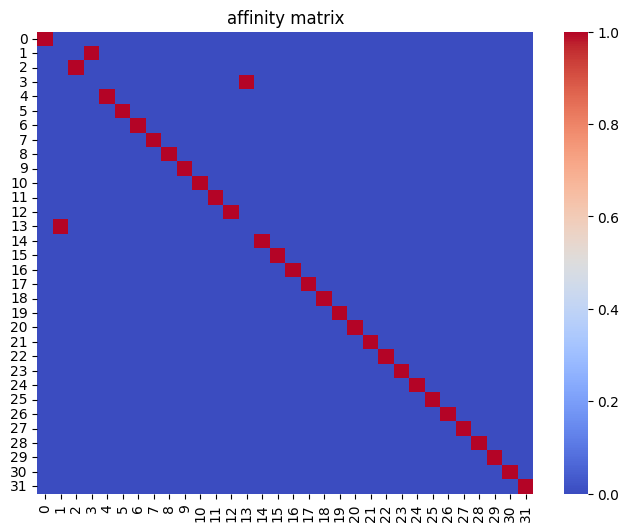

In [32]:
plt.figure(figsize=(8, 6))  # 设置热图大小
sns.heatmap(b_mtx, cmap='coolwarm', cbar=True)

# 添加标题
plt.title("affinity matrix")

In [39]:
import lap
import numpy as np
import datetime
import time 
start = time.perf_counter()
matches, unmatched_a, unmatched_b = [], [], []
cost, x, y = lap.lapjv(-match_mtx_list[0][:-1,:-1].detach().numpy(), extend_cost=False)
# for ix, mx in enumerate(x):
#     if mx >= 0:
#         matches.append([ix, mx])
# unmatched_a = np.where(x < 0)[0]
# unmatched_b = np.where(y < 0)[0]
# matches = np.asarray(matches)
# # lap.lapjv(, extend_cost=False)
# matches

lapmtx = np.zeros_like(match_mtx_list[0][:-1,:-1].detach().numpy())
lapmtx[x, y] = 1
end = time.perf_counter()

lapmtx,datetime.timedelta(seconds=end - start)

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 datetime.timedelta(microseconds=535))

In [35]:
# x,y,unmatched_b

lapmtx = np.zeros_like(match_mtx_list[0][:-1,:-1].detach().numpy())
lapmtx[x, y] = 1
lapmtx

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Text(0.5, 1.0, 'affinity matrix')

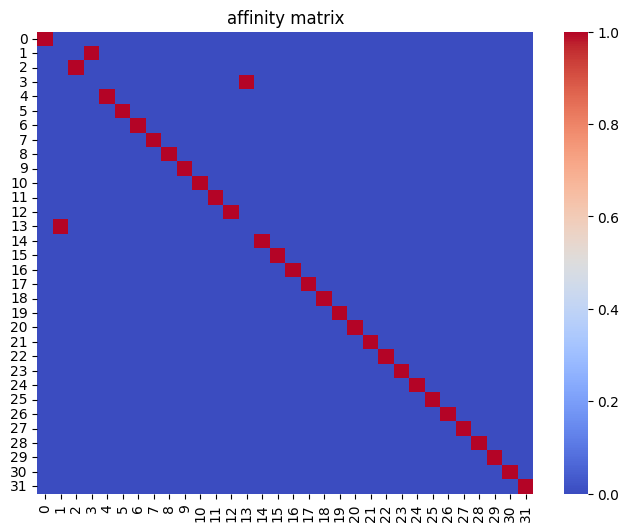

In [36]:
plt.figure(figsize=(8, 6))  # 设置热图大小
sns.heatmap(lapmtx, cmap='coolwarm', cbar=True)

# 添加标题
plt.title("affinity matrix")

# 3. 扩充数据集

In [2]:
import os 
import json
from configs.config import get_config
cfg = get_config()
# cfg.DATA_DIR

os.listdir(cfg.DATA_DIR)

['DanceTrack', 'MOT17', 'MOT20']

In [2]:
os.listdir(cfg.DATA_DIR)[2] in ['MOT17','MOT20']

True

In [5]:
save_json = {
    'train_seq':{},
    'valid_seq':{}
}

for data_type in os.listdir(cfg.DATA_DIR):
    # print(data_type)
    save_json['train_seq'][data_type] = {'seq_name':[],'start_frame':[],'end_frame':[]}
    save_json['valid_seq'][data_type] = {'seq_name':[],'start_frame':[],'end_frame':[]}

    if data_type in ['MOT17','MOT20']: # half-frame data for train  and half-frame data for validation 
        for seq in os.listdir(os.path.join(cfg.DATA_DIR,data_type,'train')):
            if not os.path.isdir(os.path.join(cfg.DATA_DIR,data_type,'train',seq)):
                continue
            seq_path = os.path.join(cfg.DATA_DIR,data_type,'train',seq)
            ini_path = os.path.join(seq_path,'seqinfo.ini')
            with open(ini_path,'r') as f:
                lines_split = [ l.split('=') for l in f.read().splitlines()[1:]]
                info_dict  = dict(s for s in lines_split if isinstance(s,list) and len(s) == 2)
            
            save_json['train_seq'][data_type]['seq_name'].append(seq)
            save_json['train_seq'][data_type]['start_frame'].append(1)
            save_json['train_seq'][data_type]['end_frame'].append(int(info_dict['seqLength'])//2)

            save_json['valid_seq'][data_type]['seq_name'].append(seq)
            save_json['valid_seq'][data_type]['start_frame'].append(int(info_dict['seqLength'])//2 + 1 )
            save_json['valid_seq'][data_type]['end_frame'].append(int(info_dict['seqLength']))

    elif data_type in ['DanceTrack']:
        for train_seq in os.listdir(os.path.join(cfg.DATA_DIR,data_type,'train')):
            if not os.path.isdir(os.path.join(cfg.DATA_DIR,data_type,'train',train_seq)):
                continue
            seq_path = os.path.join(cfg.DATA_DIR,data_type,'train',train_seq)
            ini_path = os.path.join(seq_path,'seqinfo.ini')
            with open(ini_path,'r') as f:
                lines_split = [ l.split('=') for l in f.read().splitlines()[1:]]
                info_dict  = dict(s for s in lines_split if isinstance(s,list) and len(s) == 2)

            save_json['train_seq'][data_type]['seq_name'].append(train_seq)
            save_json['train_seq'][data_type]['start_frame'].append(1)
            save_json['train_seq'][data_type]['end_frame'].append(int(info_dict['seqLength']))          

        for valid_seq in os.listdir(os.path.join(cfg.DATA_DIR,data_type,'val')):
            if not os.path.isdir(os.path.join(cfg.DATA_DIR,data_type,'val',valid_seq)):
                # print(os.path.join(cfg.DATA_DIR,data_type,'val',valid_seq))
                continue
            seq_path = os.path.join(cfg.DATA_DIR,data_type,'val',valid_seq)
            ini_path = os.path.join(seq_path,'seqinfo.ini')
            with open(ini_path,'r') as f:
                lines_split = [ l.split('=') for l in f.read().splitlines()[1:]]
                info_dict  = dict(s for s in lines_split if isinstance(s,list) and len(s) == 2)

            save_json['valid_seq'][data_type]['seq_name'].append(valid_seq)
            save_json['valid_seq'][data_type]['start_frame'].append(1)
            save_json['valid_seq'][data_type]['end_frame'].append(int(info_dict['seqLength']))
    else:
        raise ValueError('data_type not supported')

In [6]:
# save_json
import json 
with open(cfg.JSON_PATH,'w') as json_file:
    json.dump(save_json, json_file,indent=4)


In [5]:
# import tqdm
from tqdm import tqdm
import numpy as np
mode ='Train'
dets_dict = {}
frame_list = []
dataset_dir = r'datasets'
with open(cfg.JSON_PATH,'r') as f:
    if mode == 'Train':
        data_json = json.load(f)['train_seq']
    elif mode == 'Validation':
        data_json = json.load(f)['valid_seq']

for data_type in data_json.keys():
    # print(data_type)
    seq_name_list    = data_json[data_type]['seq_name']
    start_frame_list = data_json[data_type]['start_frame']
    end_frame_list   = data_json[data_type]['end_frame']
    for seq_name,start_frame,end_frame in tqdm(
            zip(seq_name_list,start_frame_list,end_frame_list),
            desc=f"[{mode}] Data-preprocess",total = len(seq_name_list),unit='seq'):               
        unique_frameidx_list = []
        dets_dict[seq_name] = {} 

        if mode == 'Train' or data_type in ['MOT17','MOT20']:
            seq_path   = os.path.join(dataset_dir,data_type,'train',seq_name)  
        elif mode == 'Validation' and data_type in ['DanceTrack']:
            seq_path   = os.path.join(dataset_dir,data_type,'val',seq_name)                         
        
        txt_path   = os.path.join(seq_path,'gt','gt.txt') 
        detections = np.loadtxt(txt_path,delimiter=',')
        valid_mask = (
            (detections[:, 2] >= 0) & (detections[:, 3] >= 0) &
            (detections[:, 4] >= 0) & (detections[:, 5] >= 0) &
            (np.isin(detections[:, 7], [1, 2, 7])) &
            (start_frame <= detections[:, 0]) & (detections[:, 0] <= end_frame)
        )
        sorted_detections = sorted(detections[valid_mask],key=lambda x:x[0])
        for detection in sorted_detections:
            x,y,w,h = map(float,detection[2:6])
            xc , yc = x + w/2 , y + h/2
            frame_idx,tracklet_id = map(int,detection[:2])
            if frame_idx not in unique_frameidx_list:
                unique_frameidx_list.append(frame_idx)
                frame_list.append(f"{data_type}*{seq_name}*{frame_idx}")
                dets_dict[seq_name][frame_idx] = []
            dets_dict[seq_name][frame_idx].append([frame_idx,tracklet_id,x,y,w,h,xc,yc])
        if mode !=  'Validation':
            frame_list.remove(f"{data_type}*{seq_name}*{1}")
# logger.info(f"[{mode}] Total frame number : {len(frame_list)}")

[Train] Data-preprocess: 100%|██████████| 4/4 [00:08<00:00,  2.06s/seq]


In [15]:
from configs.config import get_config
from utils.graphDataset import GraphDataset,graph_collate_fn
from torch.utils.data import DataLoader
import cProfile
cfg = get_config()

train_dataset = GraphDataset(cfg,'Train',True)
train_loader  = DataLoader(train_dataset,batch_size=cfg.BATCH_SIZE,shuffle=True,pin_memory=True,
                               num_workers=cfg.NUM_WORKS,collate_fn=graph_collate_fn,drop_last=True)
data_iter = iter(train_loader)
cProfile.run('next(data_iter)',filename='time.out')

[Train] Data-preprocess: 100%|██████████| 3/3 [00:11<00:00,  3.92s/dataset]
2024-12-06 18:56:38.328 | INFO     | utils.graphDataset:__init__:81 - [Train] Total frame number : 48865


DanceTrack*dancetrack0080*578
568->575
DanceTrack*dancetrack0098*568
558->568
DanceTrack*dancetrack0006*1069
1059->1068
DanceTrack*dancetrack0032*525
515->523
DanceTrack*dancetrack0075*252
242->252
DanceTrack*dancetrack0072*703
693->703
MOT20*MOT20-05*1642
1632->1640
DanceTrack*dancetrack0055*819
809->817
DanceTrack*dancetrack0052*441
431->440
DanceTrack*dancetrack0032*391
381->390
DanceTrack*dancetrack0006*273
263->273
MOT20*MOT20-03*574
564->573
DanceTrack*dancetrack0069*102
92->101
DanceTrack*dancetrack0006*846
836->846
MOT20*MOT20-02*125
115->122
MOT20*MOT20-02*499
489->498
DanceTrack*dancetrack0029*982
972->982
DanceTrack*dancetrack0027*328
318->327
DanceTrack*dancetrack0087*327
317->323
DanceTrack*dancetrack0029*420
410->416
DanceTrack*dancetrack0049*710
700->708
DanceTrack*dancetrack0082*343
333->342
DanceTrack*dancetrack0083*432
422->432
DanceTrack*dancetrack0045*337
327->337
DanceTrack*dancetrack0012*931
921->928
DanceTrack*dancetrack0039*173
163->170
MOT20*MOT20-05*1252
1242-

In [19]:
import pstats

# 创建一个 Stats 对象
p = pstats.Stats('TimeAnalysis.out')

p.sort_stats('time').print_stats(10)

Fri Dec  6 19:14:24 2024    TimeAnalysis.out

         8161163 function calls (8104533 primitive calls) in 174.691 seconds

   Ordered by: internal time
   List reduced from 1343 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       63   38.925    0.618   39.658    0.629 e:\Desktop\myTrainer(DDP)\models\core\graphEncoder.py:78(construct_edge_index)
     2585   29.794    0.012   29.794    0.012 {built-in method torch._ops.image.decode_image}
        2   19.964    9.982   23.821   11.911 e:\Desktop\myTrainer(DDP)\utils\graphDataset.py:26(__init__)
     2585   12.516    0.005   12.516    0.005 {method 'sub_' of 'torch._C._TensorBase' objects}
     2585   11.678    0.005   11.678    0.005 {method 'div_' of 'torch._C._TensorBase' objects}
    41806   11.253    0.000   11.253    0.000 {built-in method torch._C._nn.upsample_bilinear2d}
     4880    7.426    0.002    7.426    0.002 {method 'to' of 'torch._C._TensorBase' objects}
     2048